# <center> Movie Review Sentiment Analysis </center>
## <center> Classify the sentiment of sentences from the Rotten Tomatoes dataset </center>

##  Contents

Steps :
-  introduce the dataset (movie reviews with labels)
-  visualize the text data
-  preprocess text data
-  define and implement deep Learning models:  LSTM, GRU, Bi-directionnal RNN, CNN
-  implement baselines (classic preprocessing and ML algorithms): this part should come first but is less relevant for today !
      
---

* [0. Introduction](#introduction)
* [1. Exploratory Data Analysis](#eda)
* [2. Preprocessing the data](#preprocessing)
* [3. Deep Learning Algorithms](#DL)
  *  [3.1 LSTM model](#lstm)
  *  [3.2 GRU model ](#gru)
  *  [3.3 Bidirectional-GRU model](#bgru)
  *  [3.4 CNN model ](#cnn)
* [4. Machine Learning Models without RNN (baselines)](#ml)
  * [4.0 Example](#example)
  * [4.1 Preprocessing the data](#preprocessing_tfidf)
  * [4.2 Train classical ML algorithms on a vectorized data set](#ml_algo)

---


<a id='introduction'></a>
## 0. Introduction 

From https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview/description


The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.




![treebank.png](treebank.png)



More on the sentiment treebank https://nlp.stanford.edu/sentiment/treebank.html

You can also find more technical information by looking at these papers: 
- How do you predict the label of each node given a tree https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf
- How do you extract a tree from a given sentence https://nlp.stanford.edu/~manning/papers/unlexicalized-parsing.pdf

For now, just assume that the tree structure is given and that each node is labelled manually. 

In [37]:
# imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='eda'></a>
## 1. Exploratory Data Analysis 

First, we going to import the data and plot them in order to understand the specificity of the data set. The following code import the data. 

In [38]:
# Import the train, test and submission data set
train = pd.read_csv('train.tsv', sep = '\t')


In [39]:
train.head(20)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what is good for the goose,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is good for the goose,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for the goose,2


Each sentence is decomposed into smaller parts, called Phrases. The SentenceId is the number of the full sentence and the PhraseId is the number of a small part of the full sentence. 
The sentiment labels are:
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive.


In [40]:
labels = ["negative", "somewhat negative", "neutral", "somewhat positive", "positive"]
print("The first full sentence of the training set is: \n", train.Phrase[0])
print("The label of this full sentence is", labels[train.Sentiment[0]] )

The first full sentence of the training set is: 
 A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
The label of this full sentence is somewhat negative


In [41]:
a = train[train.SentenceId==1]
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
a.head(10)

C:\Users\arist\AppData\Local\Temp\ipykernel_24372\2707201255.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what is good for the goose,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is good for the goose,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for the goose,2


**4) How many subphrases are in the data set? How many original reviews?**

In [42]:
print("The number of subphrases is equal to the number of rows in the data set, which is", train.shape[0])
print("The number of original reviews in the data set is equal to the number of Id of sentences, which is",
      train.SentenceId.nunique())
#Beware, some SentenceId are missing. Therefore, the maximum SentenceId does not correspond to the number of Sentences
print("Maximum SentenceId", np.max(train.SentenceId))

The number of subphrases is equal to the number of rows in the data set, which is 156060
The number of original reviews in the data set is equal to the number of Id of sentences, which is 8529
Maximum SentenceId 8544


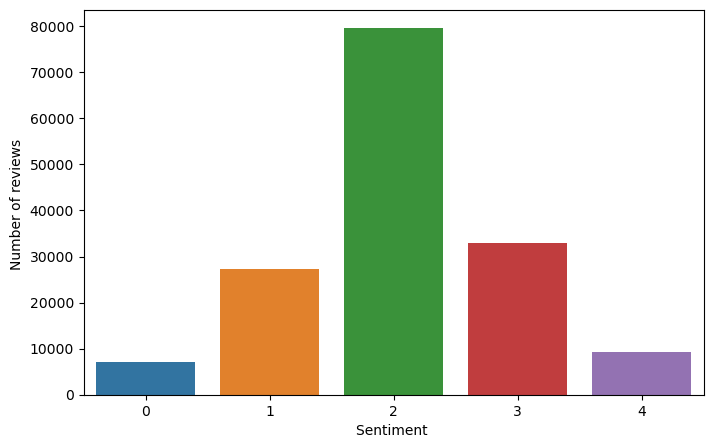

In [43]:
class_count = train['Sentiment'].value_counts()
class_count

x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8, 5))
sns.barplot(x=x, y=y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')
plt.show()

We are going to print Word Clouds. To do so, you need to install the wordcloud package here: 
https://github.com/amueller/word_cloud

If you are interested, you can find additional information on the package here: 
https://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html

**6) Use the following code to print the most frequent words of the whole training set and the most fraquent words in each class/sentiment. Any comments?**

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)


def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1  # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(9, 9))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()
    

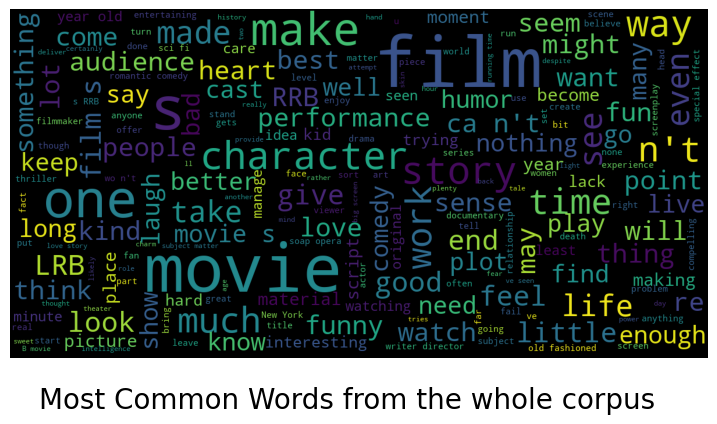

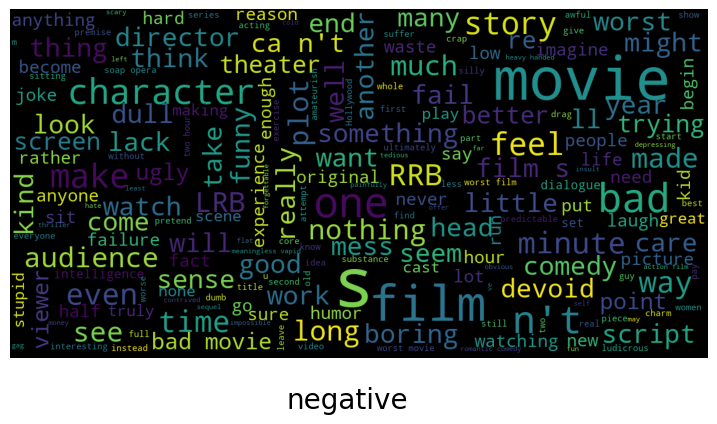

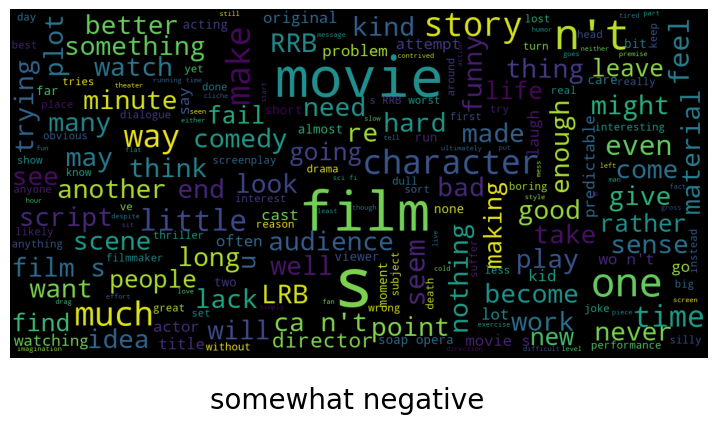

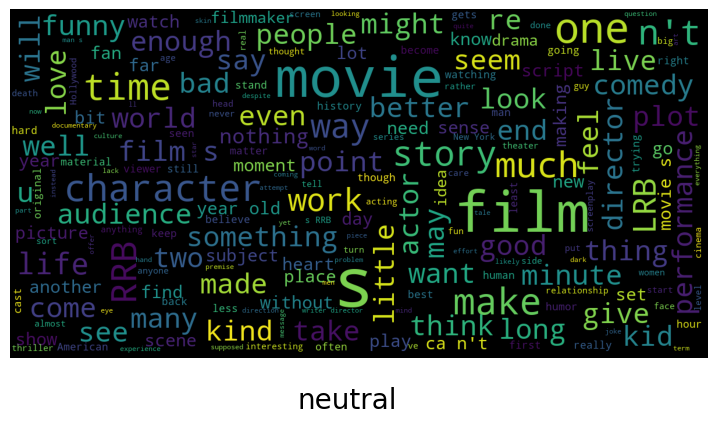

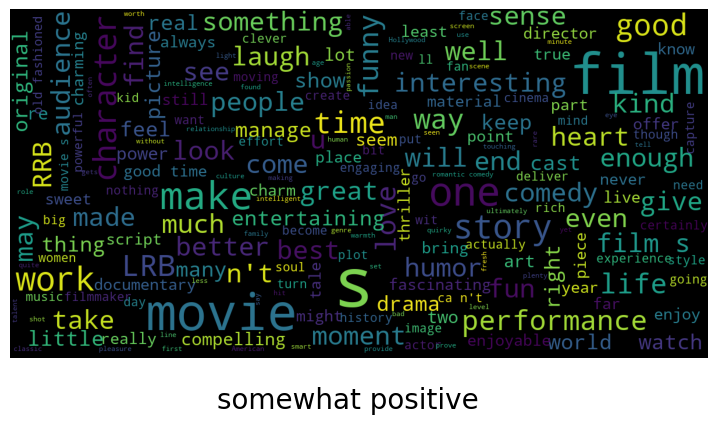

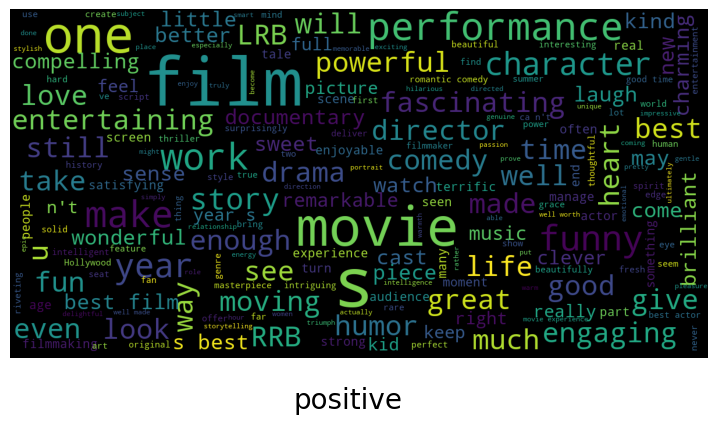

In [45]:
show_wordcloud(train['Phrase'], 'Most Common Words from the whole corpus')
show_wordcloud(train[train.Sentiment == 0]['Phrase'], labels[0])
show_wordcloud(train[train.Sentiment == 1]['Phrase'], labels[1])
show_wordcloud(train[train.Sentiment == 2]['Phrase'], labels[2])
show_wordcloud(train[train.Sentiment == 3]['Phrase'], labels[3])
show_wordcloud(train[train.Sentiment == 4]['Phrase'], labels[4])

##  2. Preprocessing 
<a id='preprocessing'></a>


Working with NLP datasets (reviews, captions, etc.) typically involves an important preprocessing of the data. 
When working with images, the observations are naturally transformed into arrays (of size number of pixels * 3) with numerical values (in [0;255] for example). The preprocessing part is often very important for natural language datasets. As we are not dealing with quantitative variables but with words in a vocabulary, we need to be careful.

**You should not spend more than 20 minutes on this part** All the details are given, and many visualizations are provided, so that you can come back afterwards to understand with more details.

We have the following steps:
- 2.1 - Create a train and a validation set from the original training set.
- 2.2 - Transform the labels into categories.
- 2.3 - Transform the lists of sentences into an array:
  - Each word is mapped to a number. 
  - Lists of numbers are padded with 0 or truncated to fit in an array

###  2.1 Create a train and a validation set from the original training set.

The original test set that we imported does not contain labels. We are going to split the training set into a training set and a validation set. Both of them will contain labels. The rows of the data set are not independent: they are subparts of some sentences. We thus need to put different **sentences** into the train and validation set: for a sentence, all phrases derived from this sentence will be put together. 

In [46]:
from sklearn.model_selection import train_test_split

#Create the indices of the sentence for the training and validation set
Sent_train, Sent_val = train_test_split(train.SentenceId.unique(), test_size=0.20)

#If you want to test the code with a smaller data set, you can try instead of the previous line
#Sent_train, Sent_val = train_test_split(train.SentenceId.unique()[0:10], test_size=0.20)

X_train = train.Phrase[train.SentenceId.isin(Sent_train)]
X_val = train.Phrase[train.SentenceId.isin(Sent_val)]
Y_train = train.Sentiment[train.SentenceId.isin(Sent_train)]
Y_val = train.Sentiment[train.SentenceId.isin(Sent_val)]


###  2.2 Transform the labels into categories.

We ransform the target into a one-hot encoded vector with the function to_categorical from keras.utils

In [47]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train.values) 
Y_val = to_categorical(Y_val.values) #TODO
Y_train


array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

### 2.3 Transform the lists of sentences into an array

In the following, we tokenize the train and test set to be able to use words are numerical variables. https://keras.io/preprocessing/text/  The function 'tokenizer' maps each word of a sentence into an integer. It thus turns a sentence into a sequence of 
integers. See for example the correspondance for the first sentence in the data set `print(X_train[0])` and `print(train.Phrase[0])`. 
The words are sorted by number of occurences. The most frequent words are associated to the smallest integers `tokenizer.word_counts`

In [48]:
max_features = 13000
num_classes = 5

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val   = tokenizer.texts_to_sequences(X_val)
tokenizer.word_index


{'the': 1,
 'a': 2,
 'of': 3,
 'and': 4,
 'to': 5,
 "'s": 6,
 'in': 7,
 'is': 8,
 'that': 9,
 'it': 10,
 'as': 11,
 'for': 12,
 'with': 13,
 'its': 14,
 'film': 15,
 'an': 16,
 'movie': 17,
 'this': 18,
 'but': 19,
 'be': 20,
 'on': 21,
 'you': 22,
 "n't": 23,
 'by': 24,
 'more': 25,
 'about': 26,
 'one': 27,
 'his': 28,
 'not': 29,
 'or': 30,
 'than': 31,
 'from': 32,
 'all': 33,
 'at': 34,
 'like': 35,
 'have': 36,
 'are': 37,
 "'": 38,
 'has': 39,
 'so': 40,
 'out': 41,
 'story': 42,
 'who': 43,
 'up': 44,
 'rrb': 45,
 'too': 46,
 'good': 47,
 'most': 48,
 'into': 49,
 'lrb': 50,
 'no': 51,
 'comedy': 52,
 'their': 53,
 'characters': 54,
 'if': 55,
 'time': 56,
 'i': 57,
 'can': 58,
 'what': 59,
 "''": 60,
 'much': 61,
 'just': 62,
 'even': 63,
 'your': 64,
 'some': 65,
 'little': 66,
 'does': 67,
 'life': 68,
 'will': 69,
 'funny': 70,
 'any': 71,
 'been': 72,
 'very': 73,
 'way': 74,
 'only': 75,
 'well': 76,
 'make': 77,
 'love': 78,
 'new': 79,
 'movies': 80,
 'which': 81,
 'he'

In order to limit the influence of the length on the predictions, we pad sequences. The length of the sentences, after transformation, will be 50. Sentences that contain less than 50 words are padded with zeros in order to contain 50 elements/words. 
Beware, the extra zeros are added in the first elements of the vector. 

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words=50

X_train = pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)


**12) Before starting implementing RNN, make sure you understand what type of data we are dealing with:**
- What is X_train, y_train?
- What are their respective sizes?
- Are the values floats, integers? What do they correspond to?
- Have we preserved the order of the sequence ?

In [54]:
X_train[0]
print(X_train.shape, X_val.shape)

(124151, 50) (31909, 50)


---
<a id='DL'></a>
# 3. Deep Learning algorithms

The goal of this part is to implement the following Recurrent Neural Networks: 
- based on LSTM
- based on GRU
- based on Bi-directional GRU
- based on CNN

For convenience, we use keras. https://towardsdatascience.com/keras-vs-pytorch-for-deep-learning-a013cb63870d


<a id='lstm'></a>
## 3.1 LSTM


The first neural network we consider uses LSTM.
See [Understanding LSTM Networks -- colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) for an excellent description of LSTM.

In [55]:
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

We create a model_LSTM this way :
- an Embedding layer (Turns positive integers (indexes) into dense vectors of fixed size see https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work)
  - how many words at most can we embed (first argument)
  - we embed those words in dimension 100 (arbitrary choice, often "enough")
  - use mask_zero=True
- an LSTM layer:
  - with 64 units, 
  - dropout of 0.5, 
  - return_sequences=True
- an LSTM layer:
  - with 32 units, 
  - dropout of 0.5, 
  - return_sequences=False
- a dense Layer :
  - what should be the dimension of the output?
  - what should be the activation?

In [56]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 100, mask_zero=True))  
model_LSTM.add(LSTM(64, dropout=0.4, return_sequences=True))  
model_LSTM.add(LSTM(32, dropout=0.5, return_sequences=False)) 
model_LSTM.add(Dense(num_classes, activation='softmax'))     


We use: 
- the categorical cross entropy for the loss
- Adam optimizer with learning rate  0.001
- accuracy for the metrics

In [58]:
model_LSTM.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=['accuracy'])

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1300000   
                                                                 
 lstm (LSTM)                 (None, None, 64)          42240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 1,354,821
Trainable params: 1,354,821
Non-trainable params: 0
_________________________________________________________________


In [59]:
batch_size = 128
epochs = 2

history3=model_LSTM.fit(X_train[1:1000], Y_train[1:1000], 
                        validation_data=(X_val[1:1000], Y_val[1:1000]),
                        epochs=epochs,
                        batch_size=batch_size, 
                        verbose=1)


Epoch 1/2
8/8 [==============================] - 14s 644ms/step - loss: 1.5957 - accuracy: 0.5706 - val_loss: 1.5934 - val_accuracy: 0.5395
Epoch 2/2
8/8 [==============================] - 2s 262ms/step - loss: 1.5487 - accuracy: 0.6607 - val_loss: 1.5879 - val_accuracy: 0.5395


<a id='gru'></a>
## 3.2 GRU

We now do the same operations again using a GRU unit instead of the LSTM unit. All the rest of the architecture remains unchanged.


You can try with loss ```categorical_crossentropy``` or ```binary_crossentropy```
(look at this to see what is best https://stackoverflow.com/questions/46354182/why-does-binary-accuracy-give-high-accuracy-while-categorical-accuracy-give-low )

In [61]:
model_GRU=Sequential()
model_GRU.add(Embedding(max_features,100,mask_zero=True))
model_GRU.add(GRU(64,dropout=0.4,return_sequences=True))
model_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model_GRU.add(Dense(num_classes,activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate = 0.001),
                  metrics=['accuracy'])
model_GRU.summary()

# %%time
history1=model_GRU.fit(X_train[1:1000], Y_train[1:1000], 
                       validation_data=(X_val[1:1000], Y_val[1:1000]),
                       epochs=epochs, 
                       batch_size=batch_size, 
                       verbose=1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1300000   
                                                                 
 gru_2 (GRU)                 (None, None, 64)          31872     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,341,445
Trainable params: 1,341,445
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
8/8 [==============================] - 16s 1s/step - loss: 1.5787 - accuracy: 0.5335 - val_loss: 1.5604 - val_accuracy: 0.5395
Epoch 2/2
8/8 [========================

We get strictly the same accuracy. 


In [62]:
model2_GRU=Sequential()

model2_GRU.add(Embedding(max_features,100,mask_zero=True))
model2_GRU.add(GRU(64,dropout=0.4,return_sequences=True))
model2_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model2_GRU.add(Dense(num_classes,activation='softmax'))

model2_GRU.compile(loss='categorical_crossentropy', 
                   optimizer=Adam(learning_rate = 0.001), 
                   metrics=['accuracy'])
model2_GRU.summary()

history2=model2_GRU.fit(X_train, Y_train, 
                        validation_data=(X_val, Y_val),
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1300000   
                                                                 
 gru_4 (GRU)                 (None, None, 64)          31872     
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,341,445
Trainable params: 1,341,445
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
970/970 [==============================] - 303s 285ms/step - loss: 1.0091 - accuracy: 0.5994 - val_loss: 1.0137 - val_accuracy: 0.6142
Epoch 2/2
970/970 [============

<a id='bgru'></a>
## 3.3 Bidirectional-GRU

We now do the same operations again using a Bidirectional GRU unit instead of the LSTM unit. All the rest of the architecture remains unchanged.

In [63]:
model_BGRU = Sequential()

model_BGRU.add(Embedding(max_features, 100, input_length=max_words))
model_BGRU.add(SpatialDropout1D(0.25))
model_BGRU.add(Bidirectional(GRU(64,dropout=0.4,return_sequences = True)))
model_BGRU.add(Bidirectional(GRU(32,dropout=0.5,return_sequences = False)))
model_BGRU.add(Dense(5, activation='softmax'))

model_BGRU.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=['accuracy'])
model_BGRU.summary()

history4=model_BGRU.fit(X_train[1:1000], Y_train[1:1000], 
                         validation_data=(X_val[1:1000], Y_val[1:1000]),
                        epochs=epochs, batch_size=batch_size, verbose=1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           1300000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          63744     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                      

Finally, you can also compare to the CNN model below.

In [64]:
model_CNN= Sequential()

model_CNN.add(Embedding(max_features,100,input_length=max_words))
model_CNN.add(Dropout(0.2))
model_CNN.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(128,activation='relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(num_classes,activation='softmax'))

model_CNN.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model_CNN.summary()

early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

history5=model_CNN.fit(X_train, Y_train, 
                       validation_data=(X_val, Y_val),
                       epochs=3, batch_size=batch_size, 
                       verbose=1,callbacks = [early_stop])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           1300000   
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            19264     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

<a id='ml'></a>
# 4. Machine Learning Models without RNN (baselines) 

We are going to use the Natural Language Toolkit NLTK package https://www.nltk.org/

``NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for 
- classification
- tokenization
- stemming
- tagging 
- parsing
- semantic reasoning
- wrappers for industrial-strength NLP libraries
- etc.

<a id='example'></a>
## 4.0 Example on a tiny corpus

A first idea to vectorize the word can be to count the number of occurrences of each word in the corpus. To understand the benefits and drawbacks of this method, let us look at a very simple/small data set. 

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

corpus = [
    'This is the first document.',
    'The document is the second document!!!',
    'And this is the third one on Patagonia.',
    'Is this the first doCUmENT?',
]

counter = CountVectorizer()
X_count = counter.fit_transform(corpus).todense()


print(counter.get_feature_names_out(), '\n')
print(X_count, '\n')

print(sum(X_count))

['and' 'document' 'first' 'is' 'on' 'one' 'patagonia' 'second' 'the'
 'third' 'this'] 

[[0 1 1 1 0 0 0 0 1 0 1]
 [0 2 0 1 0 0 0 1 2 0 0]
 [1 0 0 1 1 1 1 0 1 1 1]
 [0 1 1 1 0 0 0 0 1 0 1]] 

[[1 4 2 4 1 1 1 1 5 1 3]]


In [69]:
print("All punctuation marks are removed. The order of the words in the", 
      "sentence has obviously no impact in the count.") 

i = np.argmax(np.sum(X_count,0))
most_frequent_word = counter.get_feature_names_out()[i]

print("The most frequent word in the corpus is", most_frequent_word, 
      "which is clearly not relevant to understand the corpus.")

All punctuation marks are removed. The order of the words in the sentence has obviously no impact in the count.
The most frequent word in the corpus is the which is clearly not relevant to understand the corpus.


Counting the number of words is clearly not satisfying. Instead of a simple count, we use de **TFIDF** transform: it computes a kind of **relative importance of words**. Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- https://en.wikipedia.org/wiki/Tf%E2%80%93idf

The following code implement the TFIDF transformation.

In [71]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out(), '\n')
print(X.todense())

['and' 'document' 'first' 'is' 'on' 'one' 'patagonia' 'second' 'the'
 'third' 'this'] 

[[0.         0.45349057 0.56015108 0.37075826 0.         0.
  0.         0.         0.37075826 0.         0.45349057]
 [0.         0.63898759 0.         0.26120711 0.         0.
  0.         0.50054877 0.52241423 0.         0.        ]
 [0.40988951 0.         0.         0.21389735 0.40988951 0.40988951
  0.40988951 0.         0.21389735 0.40988951 0.26162717]
 [0.         0.45349057 0.56015108 0.37075826 0.         0.
  0.         0.         0.37075826 0.         0.45349057]]


X is a sparse matrix: since it contains many zeros it is better to store X has a sparse matrix, from a
computational and memory point of view.

In [73]:
print(type(X))

most_frequent_word = vectorizer.get_feature_names_out()[np.argmax(np.sum(X,0))]

print("The most important word with the TFIDF transformatio is", most_frequent_word, 
      "which is clearly more relevant than the one obtained with counting the words.")


<class 'scipy.sparse._csr.csr_matrix'>
The most important word with the TFIDF transformatio is document which is clearly more relevant than the one obtained with counting the words.


You can do the same operation but considering bigrams instead of onegram (a single word). The following code implement TF-IDF for bigrams. 

In [74]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)

#List of all bigrams
print(vectorizer.get_feature_names(), '\n')
#print(X.todense().shape)

#The most frequent onegram/bigram
most_frequent_word = vectorizer.get_feature_names()[np.argmax(np.sum(X,0))]
print("The most important word with the TFIDF transformation is", most_frequent_word,".")

['and', 'and this', 'document', 'document is', 'first', 'first document', 'is', 'is the', 'is this', 'on', 'on patagonia', 'one', 'one on', 'patagonia', 'second', 'second document', 'the', 'the document', 'the first', 'the second', 'the third', 'third', 'third one', 'this', 'this is', 'this the'] 

The most important word with the TFIDF transformation is document .


c:\Users\arist\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<a id='preprocessing_tfidf'></a>
## 4.1 Preprocessing of the data

Now that we have compared WordCount and TF-IDF transformation, we can go back to our original data set. We first need to vectorize the training vectors:
- we start by dividing the data set into a training set and a validation set
- we fit the tokenizer on the training set and apply it on the validation set using n-grams (only  uni-grams and bi-grams, see https://en.wikipedia.org/wiki/N-gram) and TFIDF metric


In [75]:
#Create the indices of the sentence for the training and validation set
Sent_train, Sent_val = train_test_split(train.SentenceId.unique(), test_size=0.20)

X_train = train.Phrase[train.SentenceId.isin(Sent_train)]
X_val = train.Phrase[train.SentenceId.isin(Sent_val)]
Y_train = train.Sentiment[train.SentenceId.isin(Sent_train)]
Y_val = train.Sentiment[train.SentenceId.isin(Sent_val)]

# Fit the tokenizer on the training set
# A more complicated version using a tokenizer built for tweets
#from nltk.tokenize import TweetTokenizer
#tokenizer = TweetTokenizer()
#np.set_printoptions(precision=2)
#vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)

vectorizer = TfidfVectorizer(ngram_range=(1, 1))
training_text = list(X_train.values)
vectorizer.fit(training_text)
train_vectorized = vectorizer.transform(training_text)

validation_text = list(X_val.values)
val_vectorized = vectorizer.transform(validation_text)

In [77]:
### TODO BLOCK

print("There are ",len(vectorizer.get_feature_names_out()), " n_grams in the training set.")


There are  13730  n_grams in the training set.


<a id='ml_algo'></a>
## 4.2 Train classical ML algorithms on a vectorized data set

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(train_vectorized,Y_train)
print(classification_report(ovr.predict(val_vectorized) , Y_val))
print(accuracy_score(ovr.predict(val_vectorized) , Y_val ))


c:\Users\arist\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arist\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

              precision    recall  f1-score   support

           0       0.11      0.53      0.18       292
           1       0.25      0.45      0.32      2967
           2       0.89      0.63      0.74     22205
           3       0.38      0.50      0.43      5109
           4       0.16      0.54      0.24       543

    accuracy                           0.59     31116
   macro avg       0.36      0.53      0.38     31116
weighted avg       0.72      0.59      0.63     31116

0.5897930325234606


In [79]:
svm = LinearSVC()
svm.fit(train_vectorized,Y_train)
print(classification_report( svm.predict(val_vectorized) , Y_val))
print(accuracy_score( svm.predict(val_vectorized) , Y_val ))


              precision    recall  f1-score   support

           0       0.20      0.46      0.27       611
           1       0.32      0.45      0.37      3803
           2       0.84      0.66      0.74     19955
           3       0.42      0.48      0.45      5747
           4       0.24      0.44      0.31      1000

    accuracy                           0.59     31116
   macro avg       0.40      0.50      0.43     31116
weighted avg       0.66      0.59      0.62     31116

0.5926532973389896


In [80]:
from sklearn.ensemble import VotingClassifier
estimators = [ ('svm',svm) , ('ovr' , ovr) ]
clf = VotingClassifier(estimators , voting='hard')
clf.fit(train_vectorized,Y_train)
print(classification_report( clf.predict(val_vectorized) , Y_val))
print(accuracy_score( clf.predict(val_vectorized) , Y_val ))

c:\Users\arist\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arist\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

              precision    recall  f1-score   support

           0       0.20      0.44      0.27       639
           1       0.34      0.44      0.38      4174
           2       0.86      0.65      0.74     21148
           3       0.36      0.51      0.42      4654
           4       0.15      0.56      0.24       501

    accuracy                           0.59     31116
   macro avg       0.38      0.52      0.41     31116
weighted avg       0.69      0.59      0.63     31116

0.5927818485666538


This notebook is adapted and sourced on Parth Rohilla's work, available at  https://www.kaggle.com/parth05rohilla/kernels